In [4]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [5]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_dataworth/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 


/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
starting interp point loop for 800 points
took 2.491324 seconds
run():./pestchek freyberg_pp.pst
run():./pestpp freyberg_pp.init.pst


In [6]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [7]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [8]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

Let's see which parameters matter most for to the forecasts...

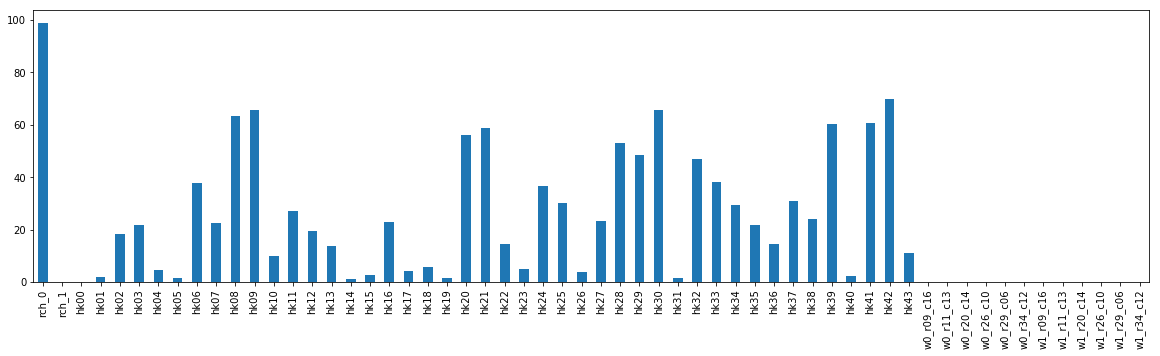

In [13]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) in arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [10]:
df_pc = sc.get_par_contribution()


In [11]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

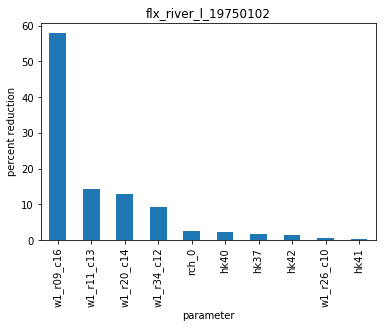

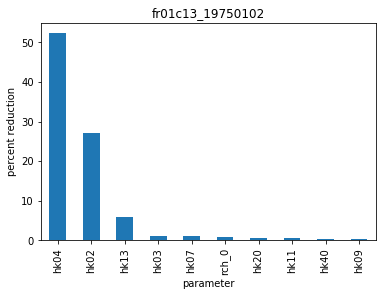

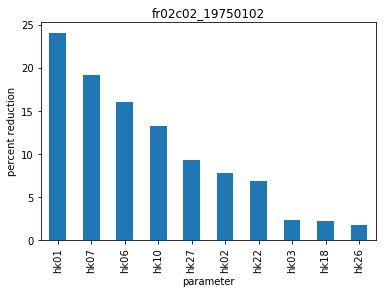

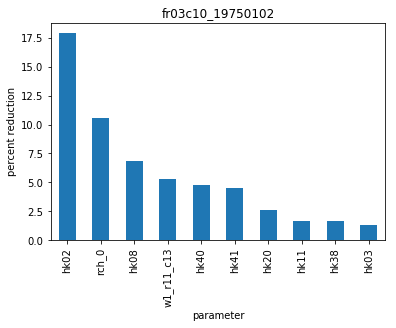

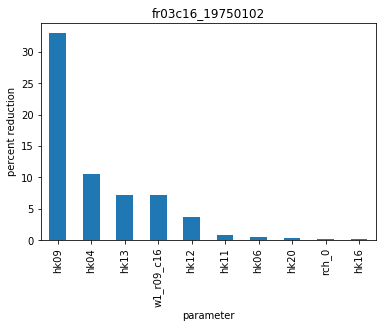

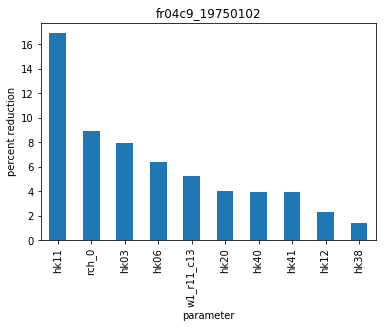

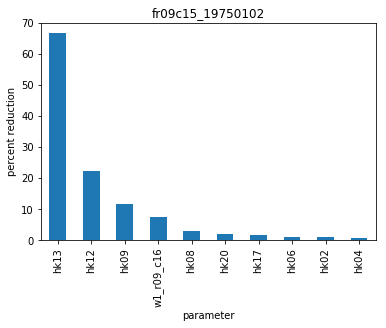

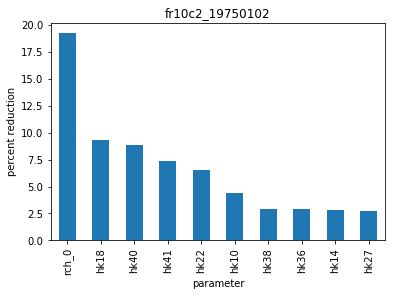

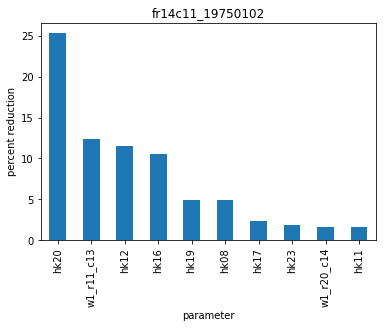

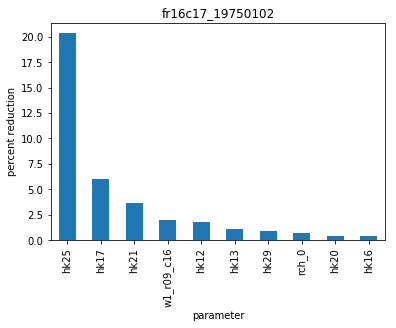

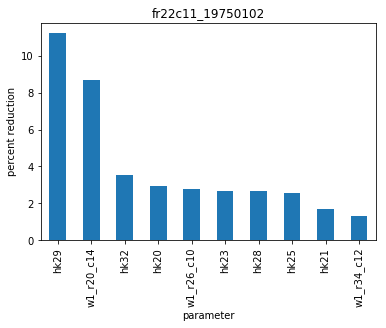

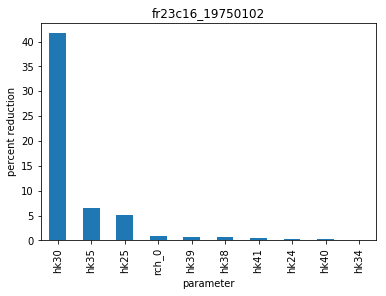

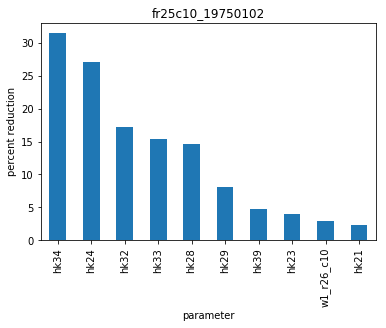

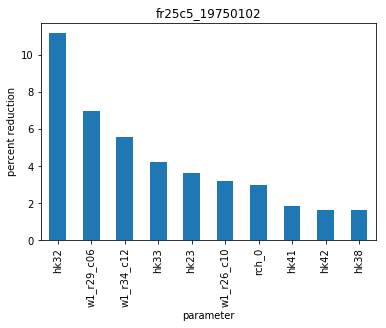

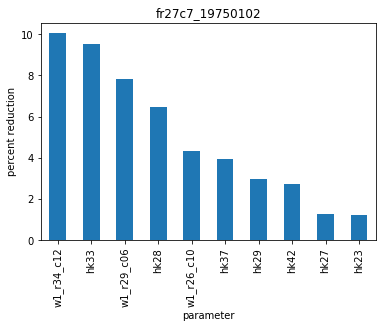

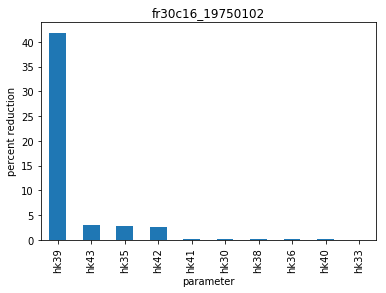

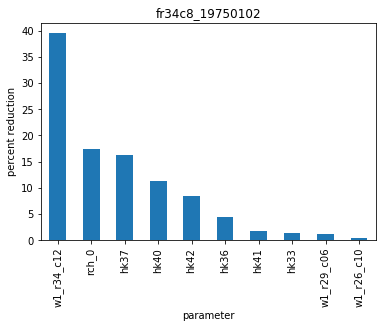

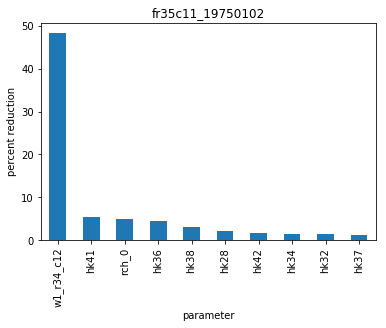

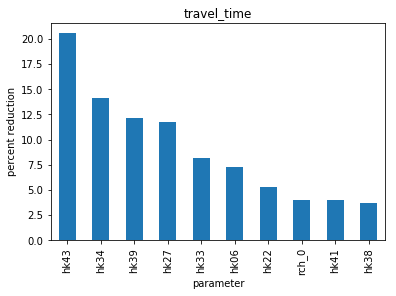

In [12]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction")
    ax.set_xlabel("parameter")
    plt.show()

We see a mixture of HK pilot points, recharge, and well pumping rates...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

Let's see what observations are most important to the forecasts using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [14]:
df_rm = sc.get_removed_obs_importance()
df_rm

,flx_river_l_19750102,fr01c13_19750102,fr02c02_19750102,fr03c10_19750102,fr03c16_19750102,fr04c9_19750102,fr09c15_19750102,fr10c2_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c10_19750102,fr25c5_19750102,fr27c7_19750102,fr30c16_19750102,fr34c8_19750102,fr35c11_19750102,travel_time
base,22312.097166,0.021169,0.906806,0.016889,0.021102,0.026779,0.631419,0.050938,0.030625,0.021106,0.019728,0.019652,0.118313,0.036573,0.035037,0.020566,0.042764,0.050698,2.231074e+07
cr27c7_19700102,22326.854977,0.021184,0.909258,0.016996,0.021106,0.026889,0.631426,0.052329,0.030683,0.021157,0.020941,0.019697,0.178397,0.036585,0.304532,0.020567,0.043578,0.050704,2.290243e+07
cr03c10_19700102,22312.125359,0.033789,0.991335,0.052454,0.021157,0.027936,0.649505,0.050972,0.031376,0.021140,0.019734,0.019652,0.118313,0.036577,0.035044,0.020566,0.042766,0.050701,2.236434e+07
cr22c11_19700102,22316.559320,0.021172,0.908491,0.016894,0.021104,0.026806,0.631722,0.051220,0.030802,0.021112,0.190710,0.019878,0.259932,0.038280,0.035291,0.020580,0.042881,0.050732,2.375962e+07
cr03c16_19700102,22312.350287,0.026314,0.907774,0.016890,0.097625,0.027534,0.758933,0.051023,0.030625,0.021550,0.019729,0.019666,0.118320,0.036574,0.035037,0.020566,0.042768,0.050700,2.231093e+07
cr30c16_19700102,22314.307117,0.021175,0.908095,0.016937,0.021103,0.026852,0.631422,0.051142,0.030627,0.021116,0.019743,0.020290,0.121522,0.036825,0.035104,0.129714,0.043064,0.050769,4.436531e+07
cr10c2_19700102,22313.112236,0.021194,2.398527,0.016949,0.021175,0.028903,0.635943,2.874461,0.030628,0.021110,0.019853,0.019652,0.118604,0.036853,0.035499,0.020566,0.042778,0.050720,2.231275e+07
cr25c5_19700102,22312.708079,0.021169,0.922838,0.016891,0.021102,0.026799,0.631419,0.050951,0.030703,0.021114,0.019782,0.019660,0.144929,0.621282,0.035229,0.020572,0.042958,0.050726,2.233251e+07
cr14c11_19700102,22312.157593,0.021264,0.906813,0.017369,0.021171,0.027722,0.638594,0.051154,0.172244,0.021223,0.020731,0.019652,0.121002,0.036829,0.035344,0.020569,0.042767,0.050699,2.233495e+07
flx_river_l_19700102,23026.794259,0.030297,1.381197,0.107550,0.023610,0.149395,0.641767,0.632377,0.043351,0.027455,0.051761,0.024133,0.182926,0.314946,0.214447,0.025928,0.109598,0.061095,3.163120e+07


In [15]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

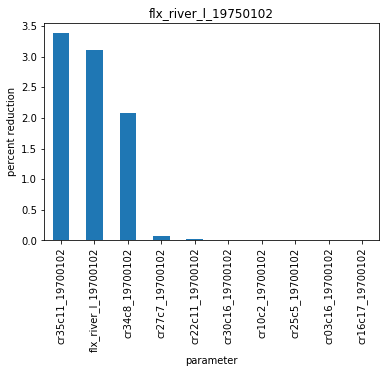

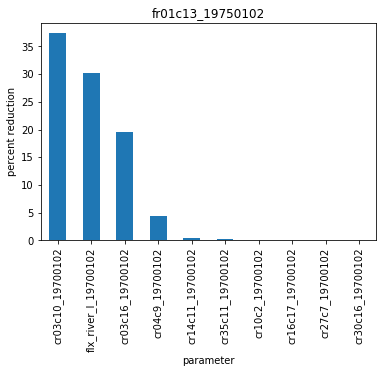

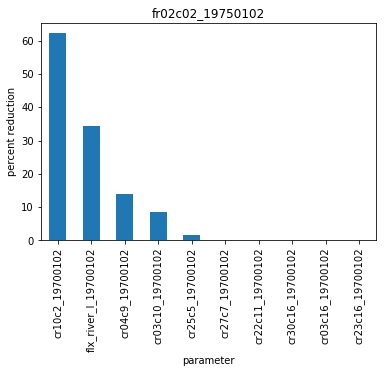

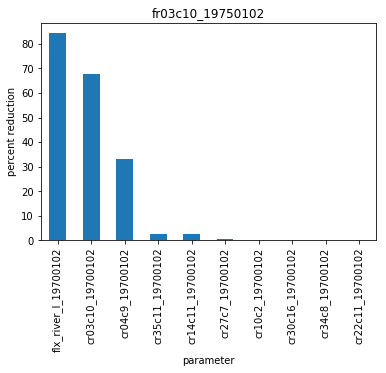

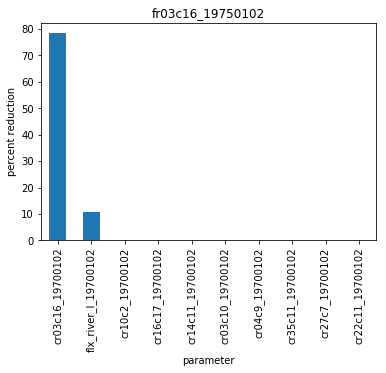

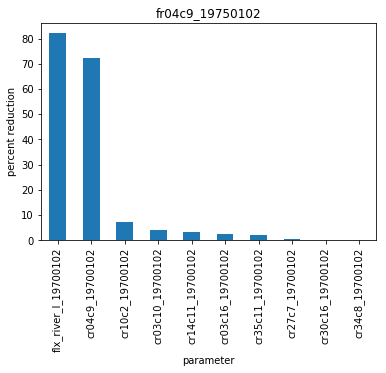

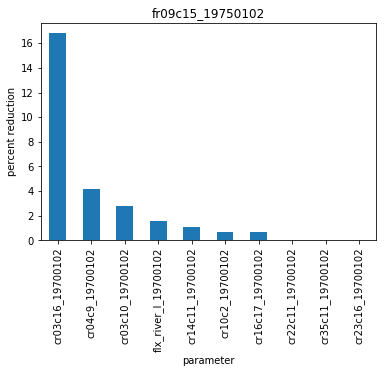

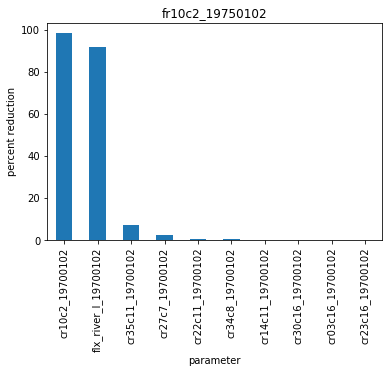

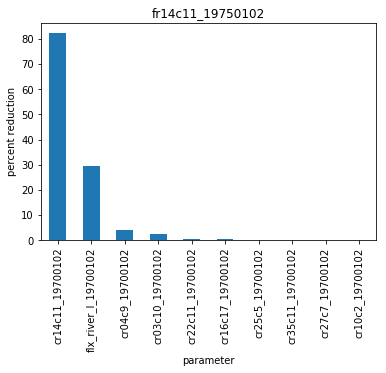

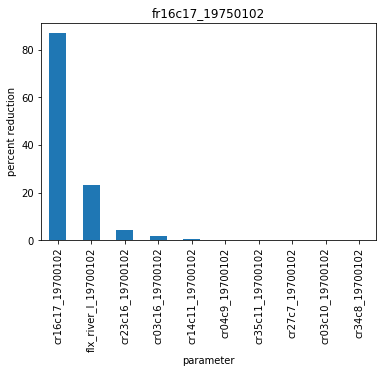

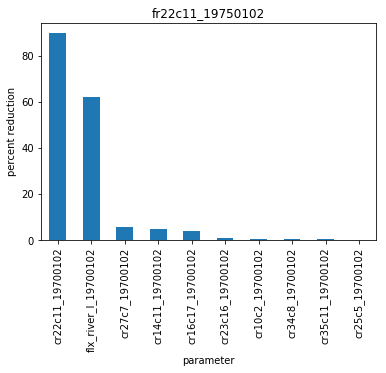

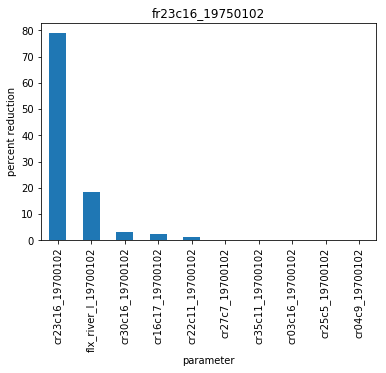

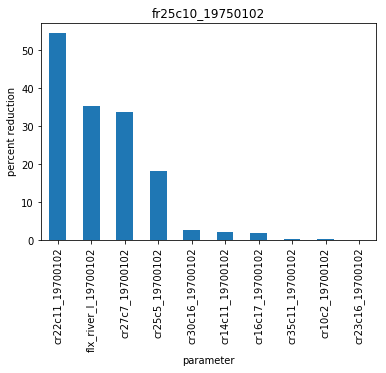

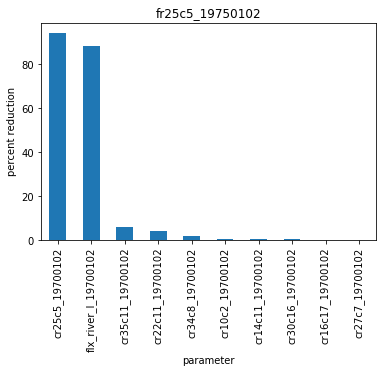

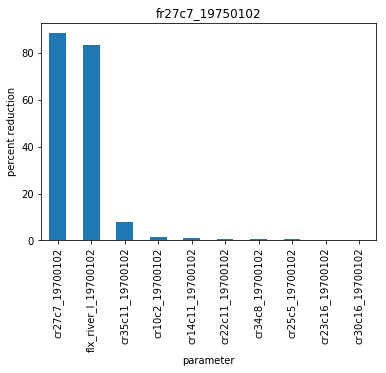

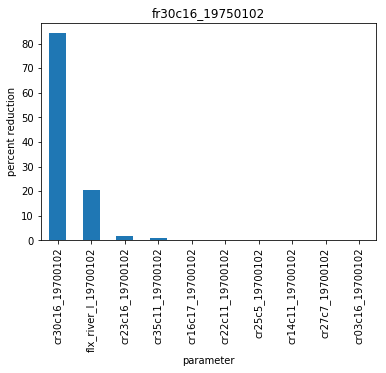

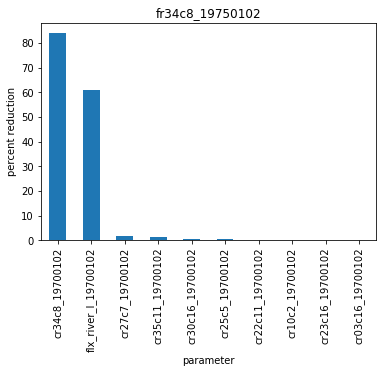

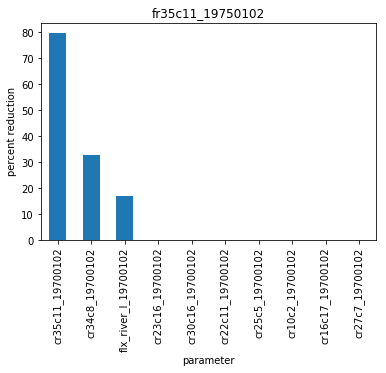

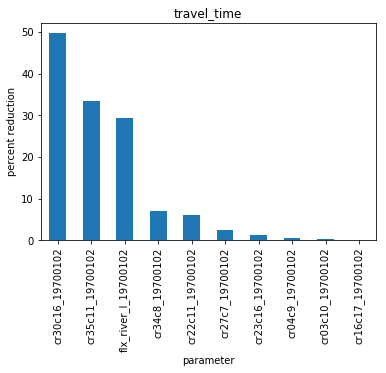

In [16]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction")
    ax.set_xlabel("parameter")
    plt.show()

In [30]:
pobs_names = [o for o in sc.pst.obs_names if o.startswith("pr")]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

In [31]:
df_ad.min()

flx_river_l_19750102    2.181659e+04
fr01c13_19750102        1.977810e-02
fr02c02_19750102        3.594650e-01
fr03c10_19750102        1.882941e-02
fr03c16_19750102        2.018072e-02
fr04c9_19750102         2.677875e-02
fr09c15_19750102        8.635321e-02
fr10c2_19750102         6.170443e-02
fr14c11_19750102        2.294970e-02
fr16c17_19750102        2.009755e-02
fr22c11_19750102        1.992551e-02
fr23c16_19750102        1.835494e-02
fr25c10_19750102        9.553825e-02
fr25c5_19750102         4.316479e-02
fr27c7_19750102         3.979707e-02
fr30c16_19750102        1.878527e-02
fr34c8_19750102         4.350055e-02
fr35c11_19750102        4.507864e-02
travel_time             1.983525e+07
dtype: float64

In [33]:
df_ad.max()

flx_river_l_19750102    2.237490e+04
fr01c13_19750102        2.137650e-02
fr02c02_19750102        9.225209e-01
fr03c10_19750102        1.986425e-02
fr03c16_19750102        2.126063e-02
fr04c9_19750102         3.095329e-02
fr09c15_19750102        6.315197e-01
fr10c2_19750102         7.243363e-02
fr14c11_19750102        3.130003e-02
fr16c17_19750102        2.124886e-02
fr22c11_19750102        2.089401e-02
fr23c16_19750102        1.982341e-02
fr25c10_19750102        1.207055e-01
fr25c5_19750102         4.700348e-02
fr27c7_19750102         4.218017e-02
fr30c16_19750102        2.074898e-02
fr34c8_19750102         4.675273e-02
fr35c11_19750102        5.418728e-02
travel_time             2.296581e+07
dtype: float64

In [34]:
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[2:4])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[5:7])-1)

    #for forecast in df_frac.columns:
        #if forecast in ["i","j"]:
        #    continue
    for forecast in sc.pst.forecast_names:
        
        arr = np.zeros((df_frac.i.max()+1,df_frac.j.max()+1)) - 1.0
        #for r,c,f in zip(df_frac.row,df_frac.column,df_frac.loc[:,forecast]):
        #    arr[r-1,c-1] = f
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0,arr)
        fig = plt.figure(figsize=(6,10))
        ax = plt.subplot(111)
        c = ax.imshow(arr,interpolation="nearest",alpha=0.5)
        #ax.imshow(zn_arr,interpolation="nearest",alpha=0.5)
        plt.colorbar(c)
        ax.set_title(forecast)
        plt.show()

    

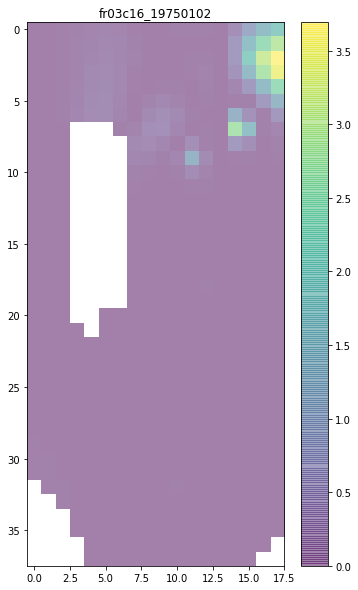

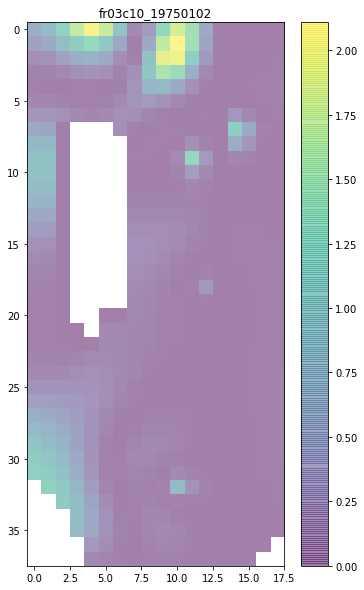

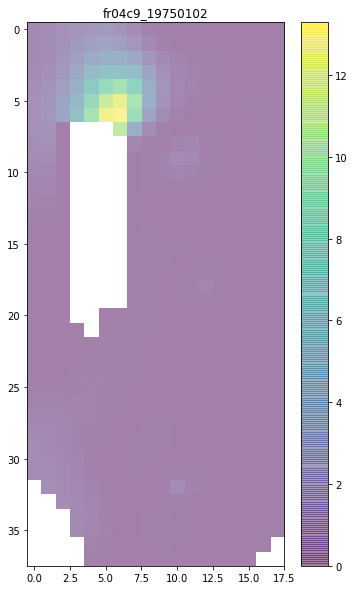

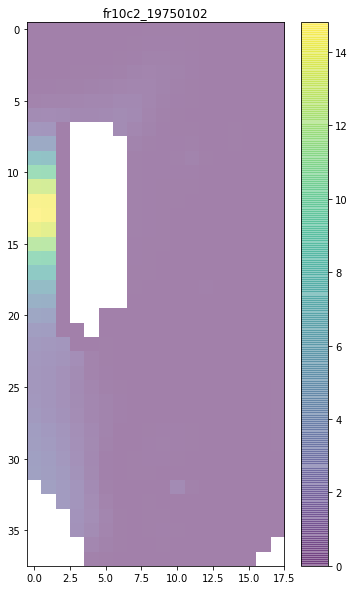

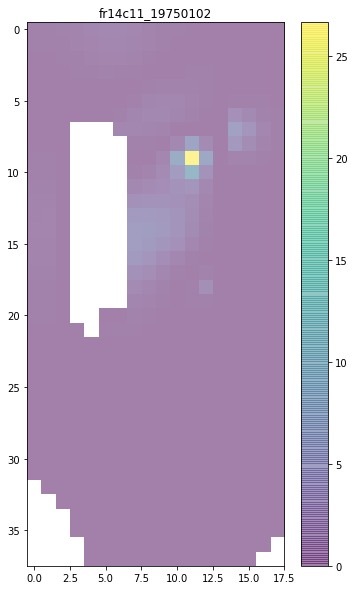

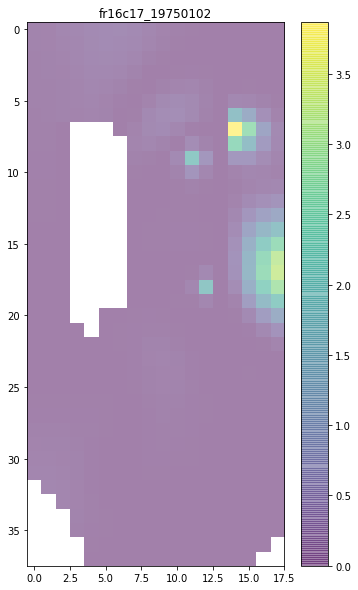

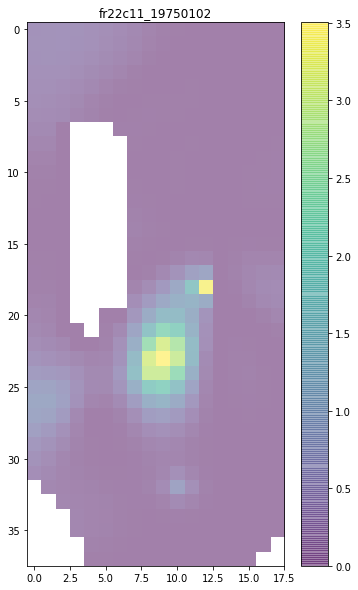

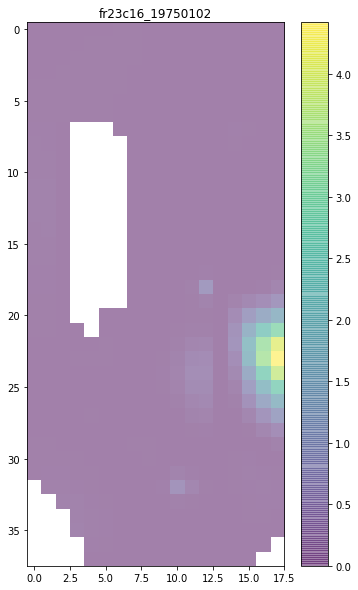

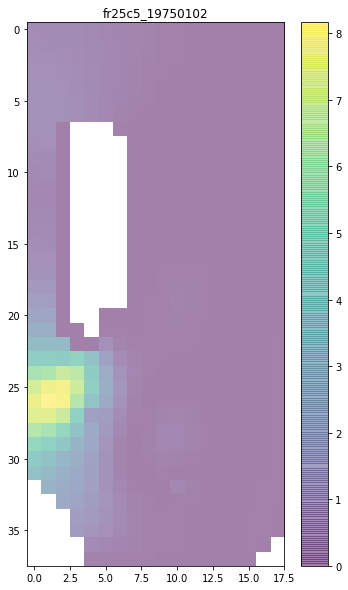

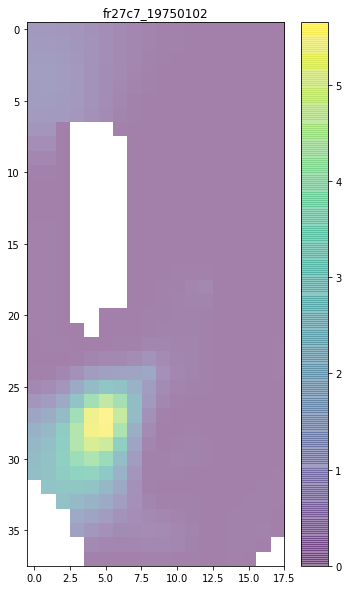

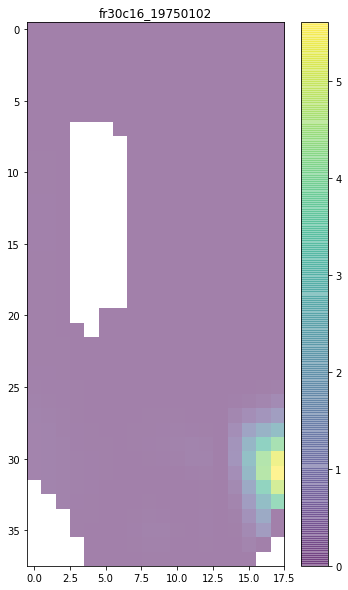

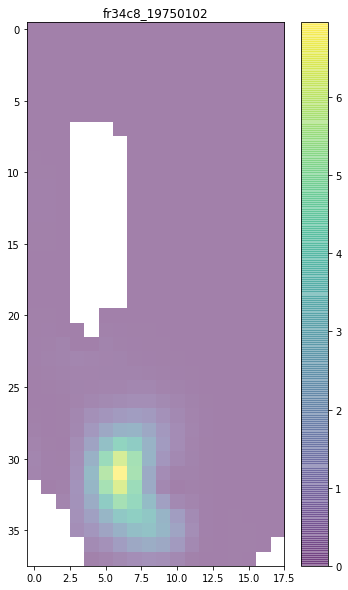

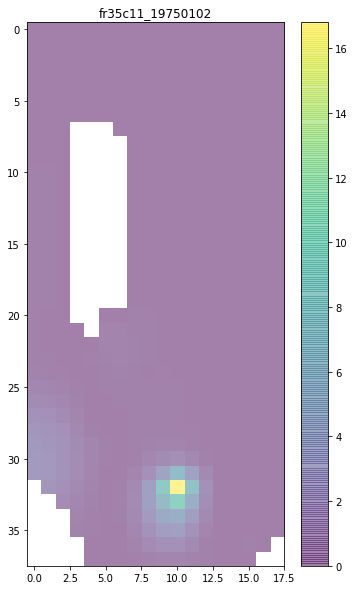

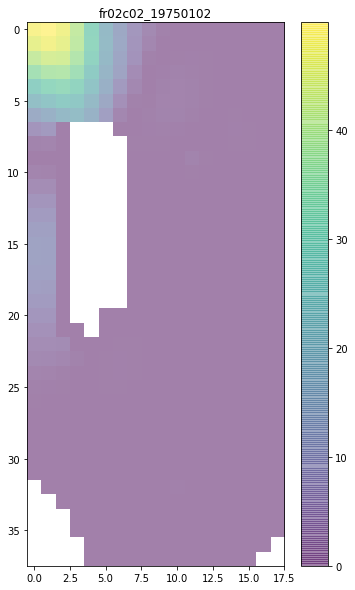

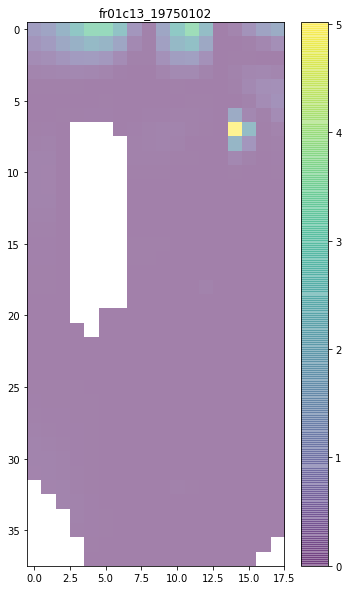

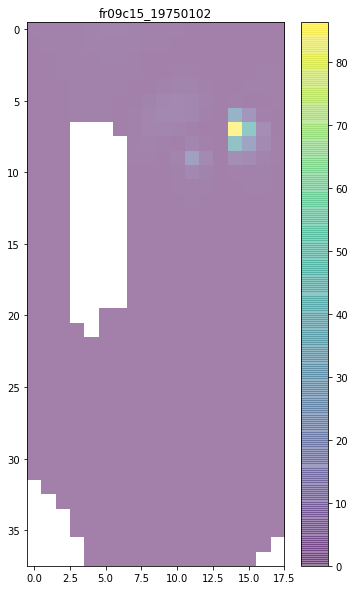

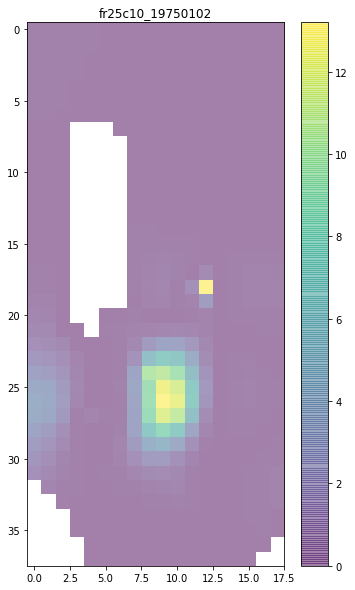

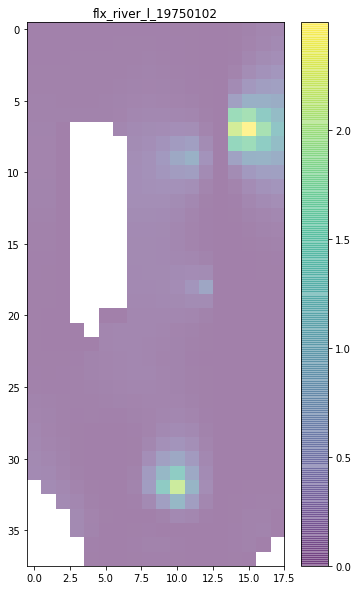

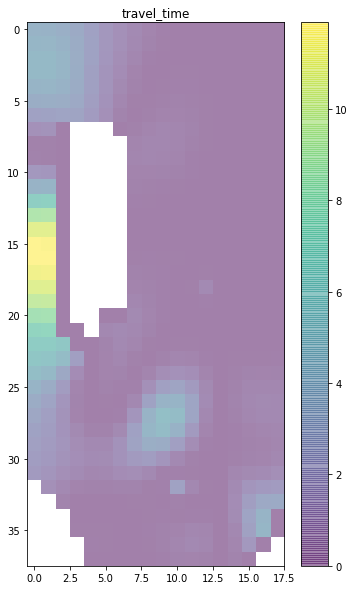

In [39]:
plot_added_worth(df_ad)

Let's explore what happens when we use a full covariance prior

In [40]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=[v])
cov = pyemu.helpers.pilotpoint_prior_builder(sc.pst,
                            struct_dict={gs:os.path.join(working_dir,"hkpp.dat.tpl")})

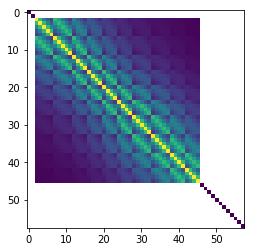

In [41]:
x = np.ma.masked_where(cov.x==0,cov.x)
plt.imshow(x)

In [42]:
sc_full = pyemu.Schur(jco=sc.jco,pst=sc.pst,parcov=cov,forecasts=sc.forecasts)

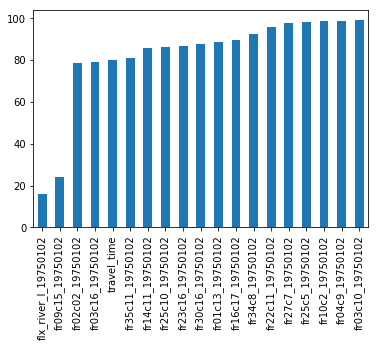

In [43]:
sc.get_forecast_summary().sort_values(by='percent_reduction').percent_reduction.plot(kind="bar")

In [49]:
df_full = sc_full.get_forecast_summary()
df_full.loc[:,"full"] = df_full.percent_reduction
df_full.loc[:,"diag"] = sc.get_forecast_summary().percent_reduction

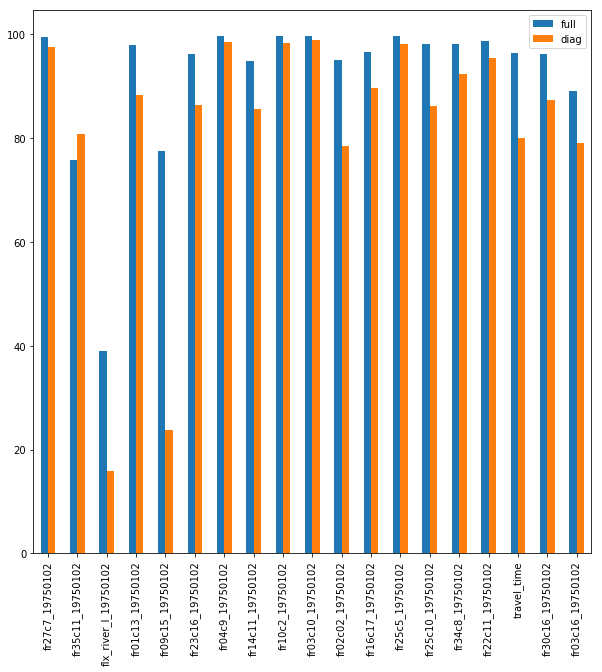

In [50]:
df_full.loc[:,["full","diag"]].plot(kind="bar",figsize=(10,10))

Why did percent reduction increase for all forecasts increase???

In [51]:
df_full.prior_var

fr27c7_19750102         7.748982e+00
fr35c11_19750102        2.174383e-01
flx_river_l_19750102    3.588482e+04
fr01c13_19750102        5.866707e-01
fr09c15_19750102        1.761416e+00
fr23c16_19750102        4.143152e-01
fr04c9_19750102         7.433556e+00
fr14c11_19750102        4.973708e-01
fr10c2_19750102         2.667925e+01
fr03c10_19750102        5.551149e+00
fr02c02_19750102        2.286963e+01
fr16c17_19750102        5.287312e-01
fr25c5_19750102         1.284000e+01
fr25c10_19750102        2.777227e+00
fr34c8_19750102         2.019401e+00
fr22c11_19750102        1.368663e+00
travel_time             4.817086e+08
fr30c16_19750102        4.671253e-01
fr03c16_19750102        1.457026e-01
Name: prior_var, dtype: float64

In [52]:
sc.get_forecast_summary().prior_var

fr27c7_19750102         1.714796e+00
fr35c11_19750102        2.807757e-01
flx_river_l_19750102    2.658873e+04
fr01c13_19750102        1.821481e-01
fr09c15_19750102        8.293621e-01
fr23c16_19750102        1.457498e-01
fr04c9_19750102         1.991566e+00
fr14c11_19750102        2.175937e-01
fr10c2_19750102         4.315901e+00
fr03c10_19750102        1.657728e+00
fr02c02_19750102        4.290906e+00
fr16c17_19750102        2.054385e-01
fr25c5_19750102         2.467100e+00
fr25c10_19750102        8.735553e-01
fr34c8_19750102         6.091313e-01
fr22c11_19750102        4.639619e-01
travel_time             1.145500e+08
fr30c16_19750102        1.643896e-01
fr03c16_19750102        1.018208e-01
Name: prior_var, dtype: float64

In [53]:
df_full = sc_full.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

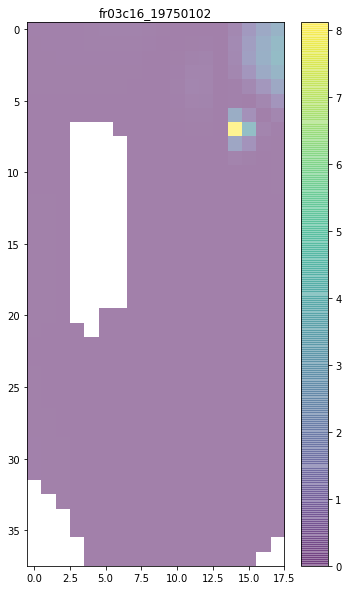

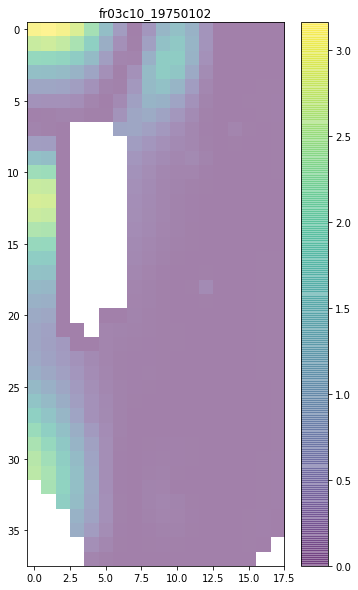

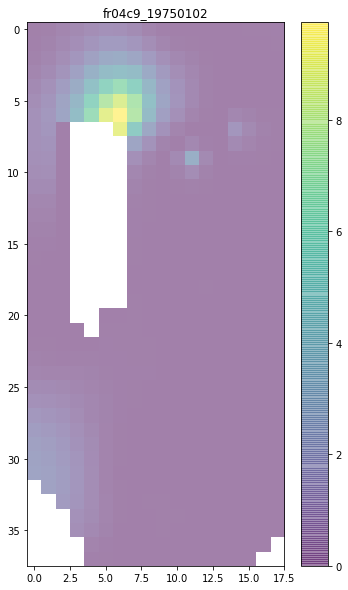

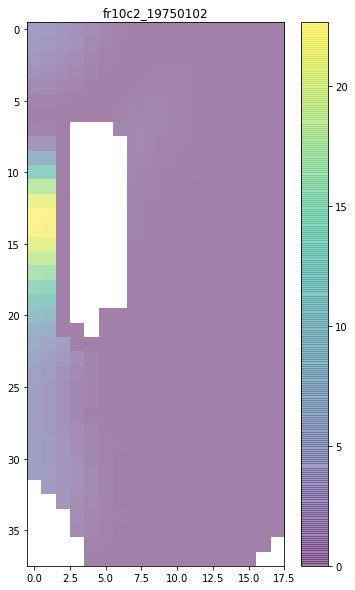

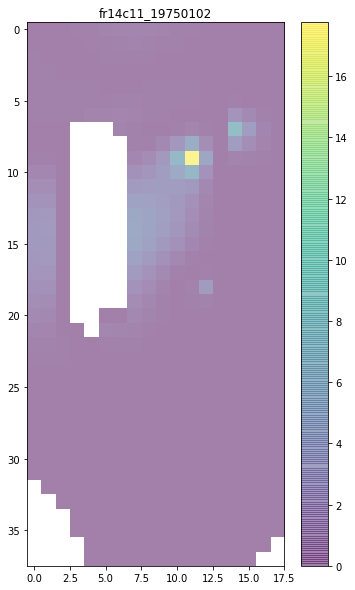

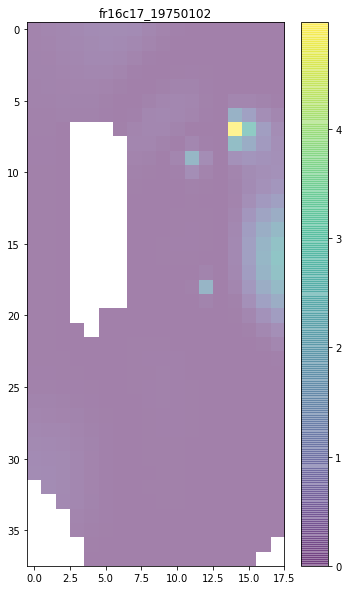

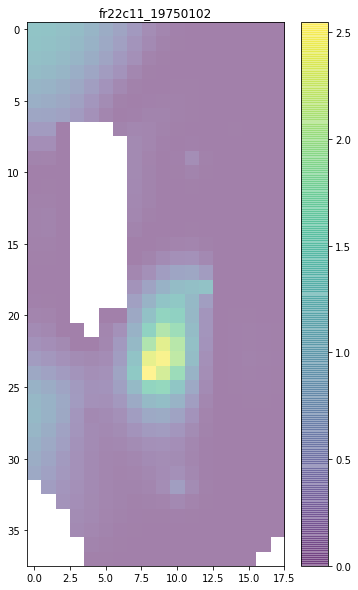

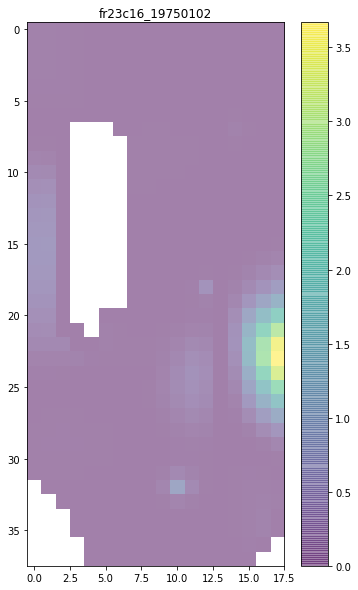

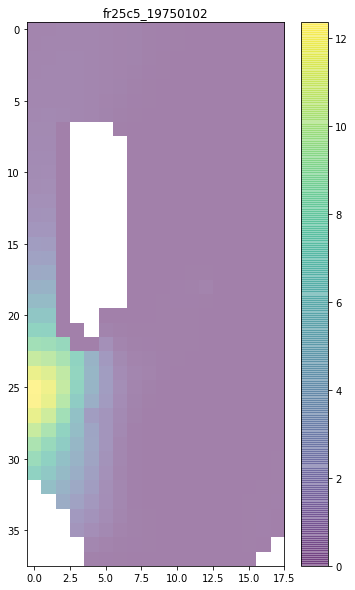

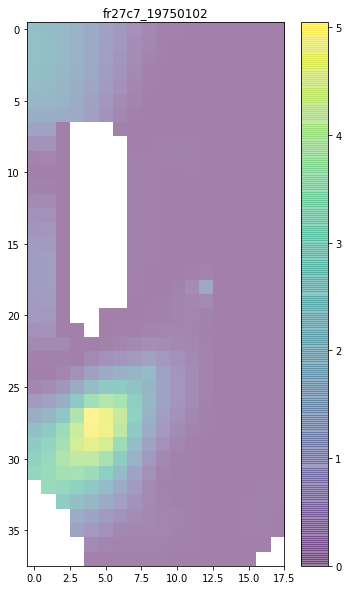

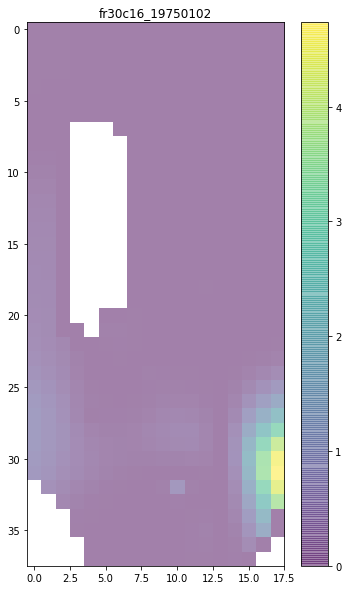

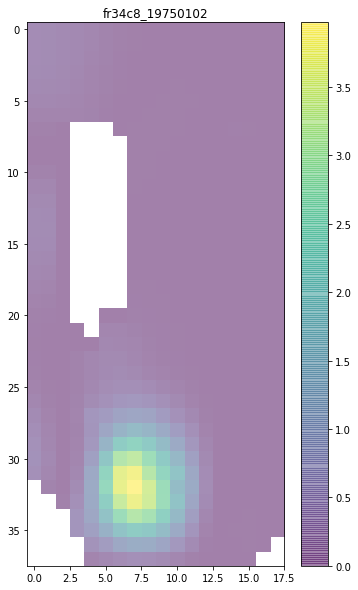

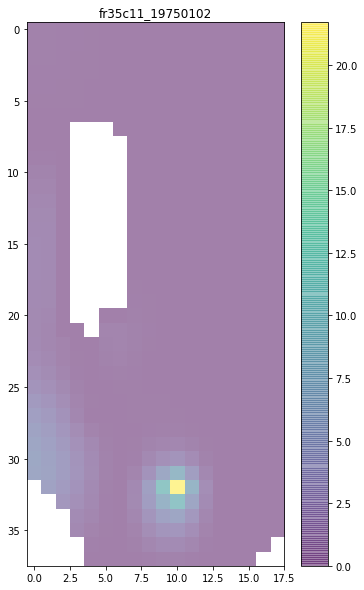

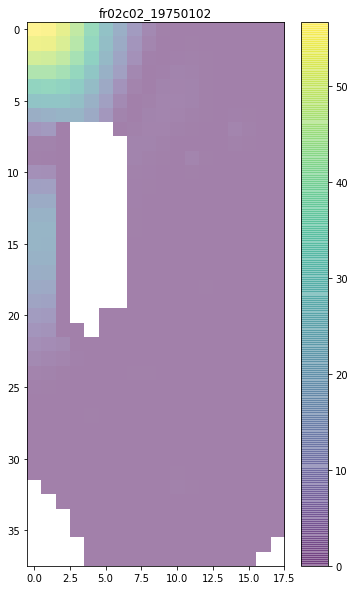

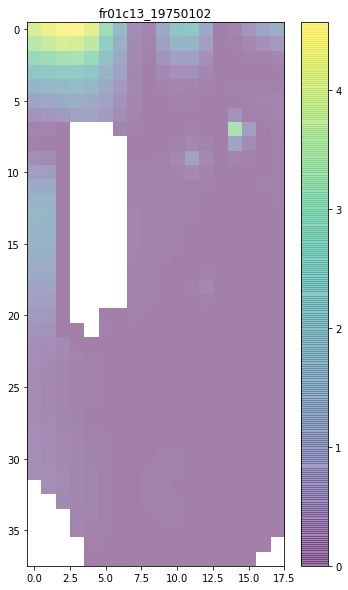

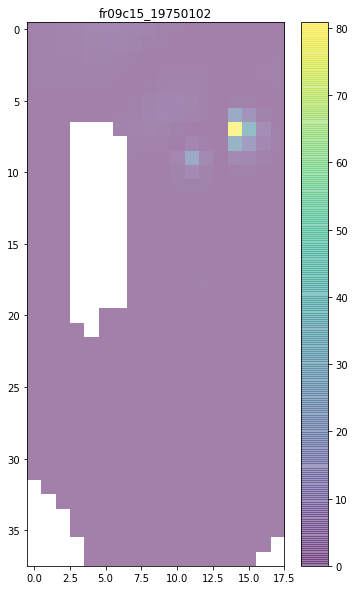

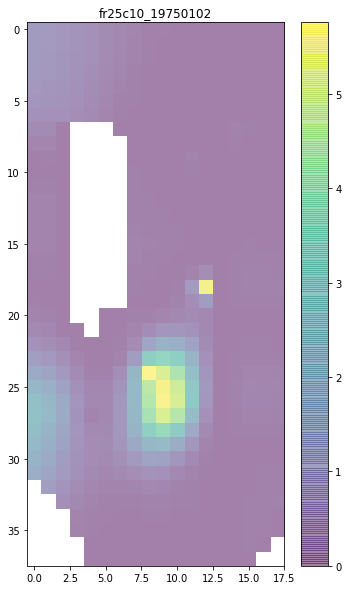

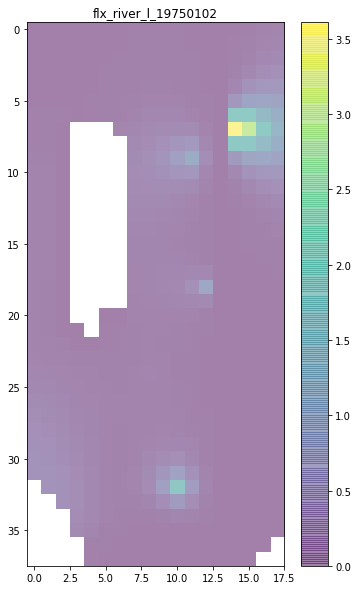

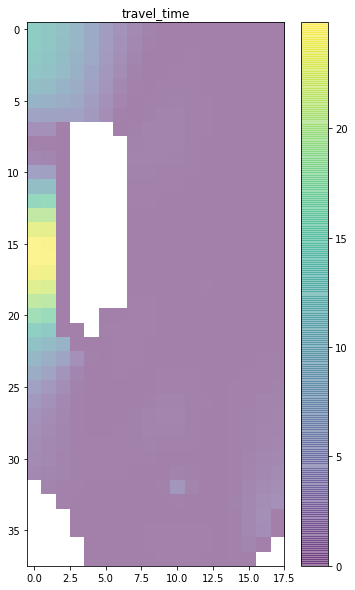

In [55]:
plot_added_worth(df_full)